                                                note  age  sex  \
0  no known chronic disease, routine checkup pain...   69    1   
1  no known chronic disease, routine checkup wors...   32    0   
2  reports cough and fever, possible infection fe...   89    0   
3  patient has history of hypertension and diabet...   78    1   
4  smoking history and chronic obstructive pulmon...   38    1   

   baseline_score  exposure  outcome  
0       -0.262979         0        0  
1       -1.835711         0        0  
2        0.330065         0        0  
3        0.619926         1        0  
4       -1.089080         0        0  
TF-IDF matrix: (2000, 196)
Reduced features: (2000, 50)
Final combined features: (2000, 53)
Average propensity score: 0.2959997509392365
Outcome model AUC: 0.6925505993502371


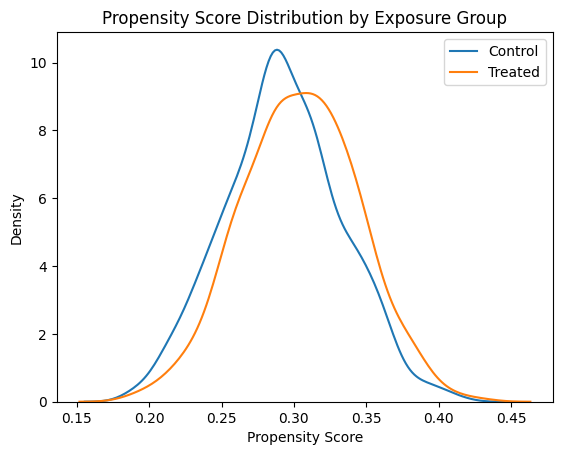

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

def simulate_ehr_notes(n=2000):
    templates = [
        "patient has history of hypertension and diabetes",
        "no known chronic disease, routine checkup",
        "diagnosed with heart failure and receiving medication",
        "reports cough and fever, possible infection",
        "history of kidney disease and dialysis",
        "smoking history and chronic obstructive pulmonary disease",
        "allergic to penicillin, mild rash previously",
        "scheduled for surgery, no other comorbidities noted"
    ]
    notes = [random.choice(templates) + " " +
             " ".join(random.choices(
                 ["pain","nausea","stable","improved","worse","fever","cough","headache"],
                 k=5)) for _ in range(n)]
    return notes

def build_synthetic_dataset(n=2000):
    notes = simulate_ehr_notes(n)
    age = np.random.randint(18,90,size=n)
    sex = np.random.choice([0,1], size=n)  # 0 female, 1 male
    baseline_score = np.random.normal(0,1,n)

    # Exposure depends on age and some text concepts
    exposure = np.random.binomial(1, p=0.3 + 0.001*(age-50), size=n)

    # Outcome depends on exposure + confounders
    outcome = (np.random.rand(n) < (0.05 + 0.2*exposure + 
                                    0.01*(age-50)/10 + 
                                    0.05*(baseline_score>1))).astype(int)

    df = pd.DataFrame({
        'note': notes,
        'age': age,
        'sex': sex,
        'baseline_score': baseline_score,
        'exposure': exposure,
        'outcome': outcome
    })
    return df

df = build_synthetic_dataset()
print(df.head())

vect = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1,2))
X_tfidf = vect.fit_transform(df['note'])
print("TF-IDF matrix:", X_tfidf.shape)

# Dimensionality reduction (like LSA)
svd = TruncatedSVD(n_components=50, random_state=RANDOM_SEED)
X_lsa = svd.fit_transform(X_tfidf)
print("Reduced features:", X_lsa.shape)

scaler = StandardScaler()
X_struct = scaler.fit_transform(df[['age','sex','baseline_score']])
X_combined = np.hstack([X_struct, X_lsa])
print("Final combined features:", X_combined.shape)

ps_model = LogisticRegression(penalty='l1', solver='saga',
                              C=1.0, max_iter=2000, random_state=RANDOM_SEED)
ps_model.fit(X_combined, df['exposure'])
propensity_scores = ps_model.predict_proba(X_combined)[:,1]

df['propensity_score'] = propensity_scores

print("Average propensity score:", df['propensity_score'].mean())

X_out = np.column_stack([df['exposure'], df['propensity_score']])
out_model = LogisticRegressionCV(cv=5, max_iter=2000).fit(X_out, df['outcome'])
preds = out_model.predict_proba(X_out)[:,1]
print("Outcome model AUC:", roc_auc_score(df['outcome'], preds))

sns.kdeplot(df.loc[df['exposure']==0,'propensity_score'], label="Control")
sns.kdeplot(df.loc[df['exposure']==1,'propensity_score'], label="Treated")
plt.title("Propensity Score Distribution by Exposure Group")
plt.xlabel("Propensity Score")
plt.legend()
plt.show()

Columns available: Index(['_id', 'description'], dtype='object')
               _id                                        description
0  trec-cds-2014-1  A 58-year-old African-American woman presents ...
1  trec-cds-2014-2  An 8-year-old male presents in March to the ER...
2  trec-cds-2014-3  A 58-year-old nonsmoker white female with mild...
3  trec-cds-2014-4  A 2-year-old boy is brought to the emergency d...
4  trec-cds-2014-5  A 56-year-old female on 20th day post-left mas...
TF-IDF matrix shape: (180142, 5000)
               _id                                        description  cluster
0  trec-cds-2014-1  A 58-year-old African-American woman presents ...        0
1  trec-cds-2014-2  An 8-year-old male presents in March to the ER...        0
2  trec-cds-2014-3  A 58-year-old nonsmoker white female with mild...        2
3  trec-cds-2014-4  A 2-year-old boy is brought to the emergency d...        4
4  trec-cds-2014-5  A 56-year-old female on 20th day post-left mas...        0


C:\Users\tanil\AppData\Local\Temp\ipykernel_41612\2444037752.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="cluster", data=df, palette="Set2")


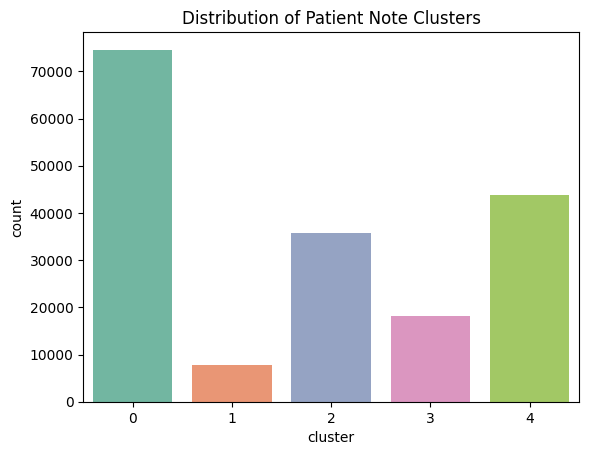

In [6]:
# Install required packages
!pip install datasets pandas scikit-learn matplotlib seaborn --quiet

# Import libraries
from datasets import load_dataset
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load Open-Patients dataset
ds = load_dataset("ncbi/Open-Patients")
df = ds["train"].to_pandas()

# Show available columns
print("Columns available:", df.columns)
print(df.head())

# Extract patient notes from 'description' column
df = df.dropna(subset=["description"])
texts = df["description"].tolist()

# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X = vectorizer.fit_transform(texts)
print("TF-IDF matrix shape:", X.shape)

# Cluster patient notes using KMeans
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)

# Add cluster labels to DataFrame
df["cluster"] = clusters
print(df.head())

# Plot cluster distribution
sns.countplot(x="cluster", data=df, palette="Set2")
plt.title("Distribution of Patient Note Clusters")
plt.show()